# TRAPPIST-1 in the context of the MLSDSS-GaiaDR2 sample

**Authors**

Rocio Kiman

**Goals:**
   * Show how to make the color-magnitude diagrams using the MLSDSS-GaiaDR2 sample described in [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract). 
   * Show an example of overploting other M dwarfs to compare their position on the color-magnitude diagram plus two other quantities: H$\alpha$ fractional luminosity and tangential velocity. 
   
**Sumary:**

In this notebook we will re-do several of the color-magnitude diagrams in [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract) using the MLSDSS-GaiaDR2 sample of M and L dwarfs decribed in that paper and we will add the TRAPPIST-1 star for comparison. 


### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits, ascii
from astropy.table import Table
from corner import hist2d
%config InlineBackend.figure_format = 'retina'

## MLSDSS-GaiaDR2 sample

The MLSDSS-GaiaDR2 sample, decribed in [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract) can be download to our computer from [Zenodo](https://zenodo.org/record/2636692#.XS93gpNKjVo). Here we are going to download it for the notebook so we do not need to store it in our computer.

In [3]:
target_url = 'https://zenodo.org/record/2636692/files/MLSDSS-GaiaDR2_extended.fits?download=1'

In [4]:
mlsdss = fits.open(target_url)

These are the quantities we need for the color-magnitude diagrams.

In [5]:
G = mlsdss[1].data['phot_g_mean_mag']
RP = mlsdss[1].data['phot_rp_mean_mag']
BP = mlsdss[1].data['phot_bp_mean_mag']
G_RP = G-RP
parallax = mlsdss[1].data['parallax']
dist = 1e3/parallax
G_abs = G + 5.0 - 5.0*np.log10(dist)
spt = mlsdss[1].data['SPT']
pmra = mlsdss[1].data['PMRA']
pmdec = mlsdss[1].data['PMDEC']
lhalbol = mlsdss[1].data['LHALBOL']
actha = mlsdss[1].data['ACTHA'] 
wdm = mlsdss[1].data['WDM'] 
r_ext = mlsdss[1].data['EXTINCTION'][:,2]
z_ext = mlsdss[1].data['EXTINCTION'][:,4]
ext = r_ext-z_ext
v_tan = 4.74*(np.sqrt(pmra**2 + pmdec**2)/1e3)*dist

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


### Flags to select good data

Below are four flags we will use to select:
   * good photometric and astrometric data: The Subred sample

In [6]:
subred = mlsdss[1].data['photometric_sample_subred'] == 1

   * magnetically active and inactive stars and are not binaries with a white dwarf companion
   

In [7]:
mask_active = (actha==1) * (wdm == 0)
mask_inactive = (actha==0) * (wdm == 0)

   * stars that don't need extinction correction

In [8]:
mask_ext = ext < 0.1

See [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract) for the description of each one of these flags.

## TRAPPIST-1

Now we select the stars we want to overplot. In this case, we are going to use TRAPPIST-1. 

**If you want to overplot different m dwarfs, just fill this cell with the information of your stars**. 

In [20]:
G_t = 15.645122 #Ref 1
BP_t = 18.9982 #Ref 1
RP_t = 14.0967 #Ref 1
parallax_t = 80.4512 #Ref 1
pmra_t = 930.879 #Ref 1
pmdec_t = -479.403 #Ref 1
spt_t = 7.5  #Ref 2
lhalbol_t = np.mean(np.array([-4.85,-4.60])) #Ref 3

In [18]:
G_RP_t = G_t - RP_t 
dist_t = 1e3/parallax_t
G_abs_t = G_t + 5.0 - 5.0*np.log10(dist_t) 
v_tan_t = 4.74*(np.sqrt(pmra_t**2 + pmdec_t**2)/1e3)*dist_t

References:
1) Gonzales et al. in prep 
2) Gizis et al. (2000)
3) Barnes et al. (2014)

### CMD color-coded with spt

For this CMD we are going to choose a very specific cmap. We are going to make darker one of python's cmaps, using a function from the [SciPy Cookbook](https://scipy-cookbook.readthedocs.io/items/Matplotlib_ColormapTransformations.html).

In [6]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [7]:
dark_RdYlBu = cmap_map(lambda x: x*0.75, matplotlib.cm.RdYlBu_r)

We also need the mean Gaia colors for each spectral type. This table was published in [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract).

In [6]:
colors_mean = np.array([0.93, 1.09, 1.23, 1.41, 1.57, 1.67]) #[M0,M2,M4,M6,M8,L0]

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


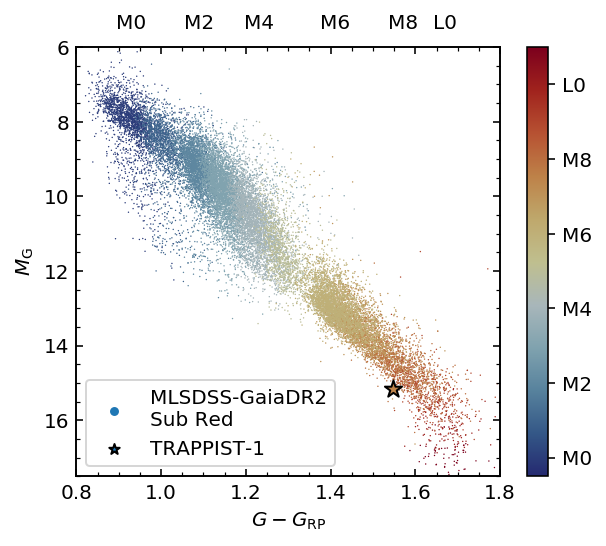

In [9]:
size = 30
fig = plt.figure(figsize=(4.5,4), edgecolor='k')
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

im1 = ax1.scatter(G[subred]-RP[subred],G_abs[subred], c=spt[subred], marker='o',
            s=0.5,label='MLSDSS-GaiaDR2\nSub Red', vmin=-0.5, vmax=11, cmap=dark_RdYlBu,zorder=0,linewidths=0)
ax1.set_ylim(19,6)
ax1.set_xlim(0.8,1.8)
ax1.set_xlabel(r'$G-G_{\rm RP}$')
ax1.set_ylabel(r'$M_{\rm G}$')

ax1.scatter(np.array([G_t,0])-np.array([RP_t,0]),np.array([G_abs_t,0]),
            c=np.array([spt_t,0]),marker='*',s=80,
            label='TRAPPIST-1', vmin=-0.5, vmax=11, cmap=dark_RdYlBu,zorder=1,
            edgecolor='black')

legend = ax1.legend(loc=3)
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [30]

cbar = fig.colorbar(im1, orientation='vertical',ticks=range(0,20,2))
cbar.set_ticklabels(['M0','M2','M4','M6','M8','L0','L2','L4','L6','L8'])

ax2.set_xticks(colors_mean)
ax2.set_xticklabels(['M0','M2','M4','M6','M8','L0'])
ax2.set_xlim(0.8,1.8)
ax2.set_ylim(17.5,6)
ax2.tick_params('x',top='off')
plt.tight_layout()
ax1.tick_params('both',direction='in',top=True,right=True)
ax1.minorticks_on()
ax1.tick_params('both',which='minor',direction='in',top=True,right=True)
plt.savefig('CMD_spt.png',dpi=300)
plt.show()

### CMD color-coded with H$\alpha$ fractional luminosity

Refer to [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract) for the analysis of the next color-magnitude diagram.

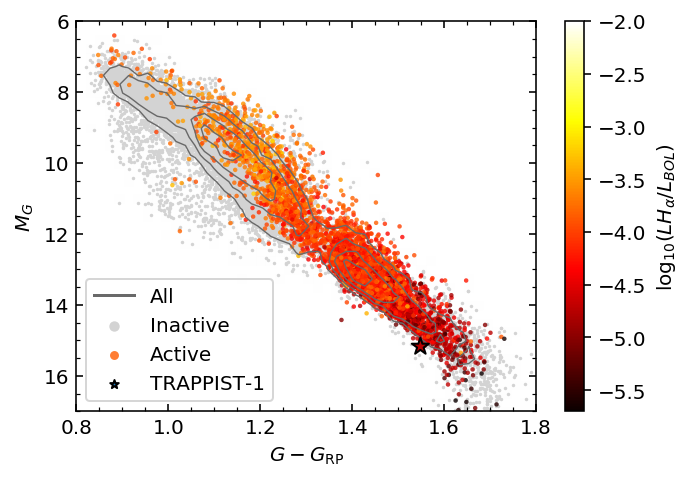

In [11]:
contour_color = 'dimgray'

plt.figure(figsize=(5,3.5))

hist2d(G_RP[subred*mask_ext], G_abs[subred*mask_ext],
       bins=50,plot_contours=True,plot_datapoints=False, color=contour_color,
       contour_kwargs={"linewidths":0.7})
plt.scatter(G_RP[subred*mask_inactive*mask_ext], G_abs[subred*mask_inactive*mask_ext], 
            color='lightgray',
            s=3,zorder=1, vmax=-2.0, vmin=-5.7, linewidths=0,label='Inactive')
plt.scatter(G_RP[subred*mask_active*mask_ext], G_abs[subred*mask_active*mask_ext], 
            c=np.log10(lhalbol[subred*mask_active*mask_ext]),cmap='hot',
            s=5,zorder=1, vmax=-2.0, vmin=-5.7, linewidths=0,label='Active',alpha=0.8)
plt.plot([0,1],[0,1],color=contour_color,label='All')
plt.scatter(np.array([G_t,0])-np.array([RP_t,0]),np.array([G_abs_t,0]),
            c=np.array([lhalbol_t,0]),marker='*',s=80,
            label='TRAPPIST-1', vmax=-2.0, vmin=-5.7, cmap='hot',zorder=3,
            edgecolor='black')

plt.gca().invert_yaxis()
plt.ylim(17,6)
plt.xlim(0.8,1.8)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$M_G$')
legend2 = plt.legend(markerscale=3, loc=3)
legend2.legendHandles[2].set_color(plt.cm.hot(0.5))
legend2.legendHandles[2]._sizes = [20]
legend2.legendHandles[3]._sizes = [20]
plt.colorbar(label = r'$\log_{10}(LH_\alpha/L_{BOL})$')

plt.tick_params('both',direction='in',top=True,right=True)
plt.minorticks_on()
plt.tick_params('both',which='minor',direction='in',top=True,right=True)

plt.tight_layout()
plt.savefig('CMD_halpha.png',dpi=300)
plt.show()

### CMD color-coded with tangential velocity

Refer to [Kiman et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....157..231K/abstract) for the analysis of the next color-magnitude diagram.

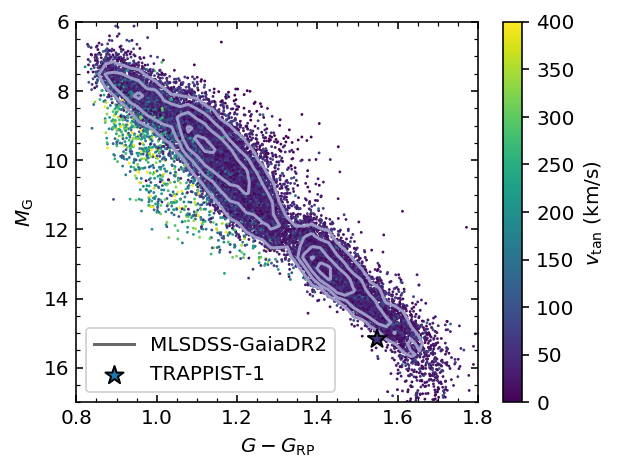

In [15]:
markersize=2
size=20

plt.figure(figsize=(4.5,3.5))
hist2d(G_RP[subred], G_abs[subred],
       bins=50,plot_contours=True,plot_datapoints=False,color='#9e9ac8')
plt.scatter(G_RP[subred], G_abs[subred], 
            c=v_tan[subred], 
            s=markersize, zorder=1, vmin=0,vmax=400, linewidths=0)
plt.plot([0,1],[0,1],color='dimgray',label='MLSDSS-GaiaDR2')

plt.scatter(np.array([G_RP_t,0]),np.array([G_abs_t,0]),
            c=np.array([v_tan_t,0]),marker='*',s=90,
            label='TRAPPIST-1', vmin=0,vmax=400,zorder=2,
            edgecolor='black')

cbar = plt.colorbar()
cbar.ax.set_yticklabels(np.arange(0,450,50))
cbar.set_label(r'$v_{\rm tan}$ $({\rm km/s})$ ')
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$M_{\rm G}$')
plt.ylim(17,6)
plt.xlim(0.8,1.8)
plt.tick_params('both',direction='in',top=True,right=True)
plt.minorticks_on()
plt.tick_params('both',which='minor',direction='in',top=True,right=True)
plt.legend()
plt.savefig('CMD_vtan.png',dpi=300)

plt.show()